In [28]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score


In [18]:
csv = "../../data/contaminated/contaminated_data1.csv"
contaminated = pd.read_csv(csv).iloc[:, 0]
indices = np.load("../../data/contaminated/indices_anomalies.npy").flatten().tolist()

In [19]:
def vetorisation_sbert(data, indice_anomalie=None):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

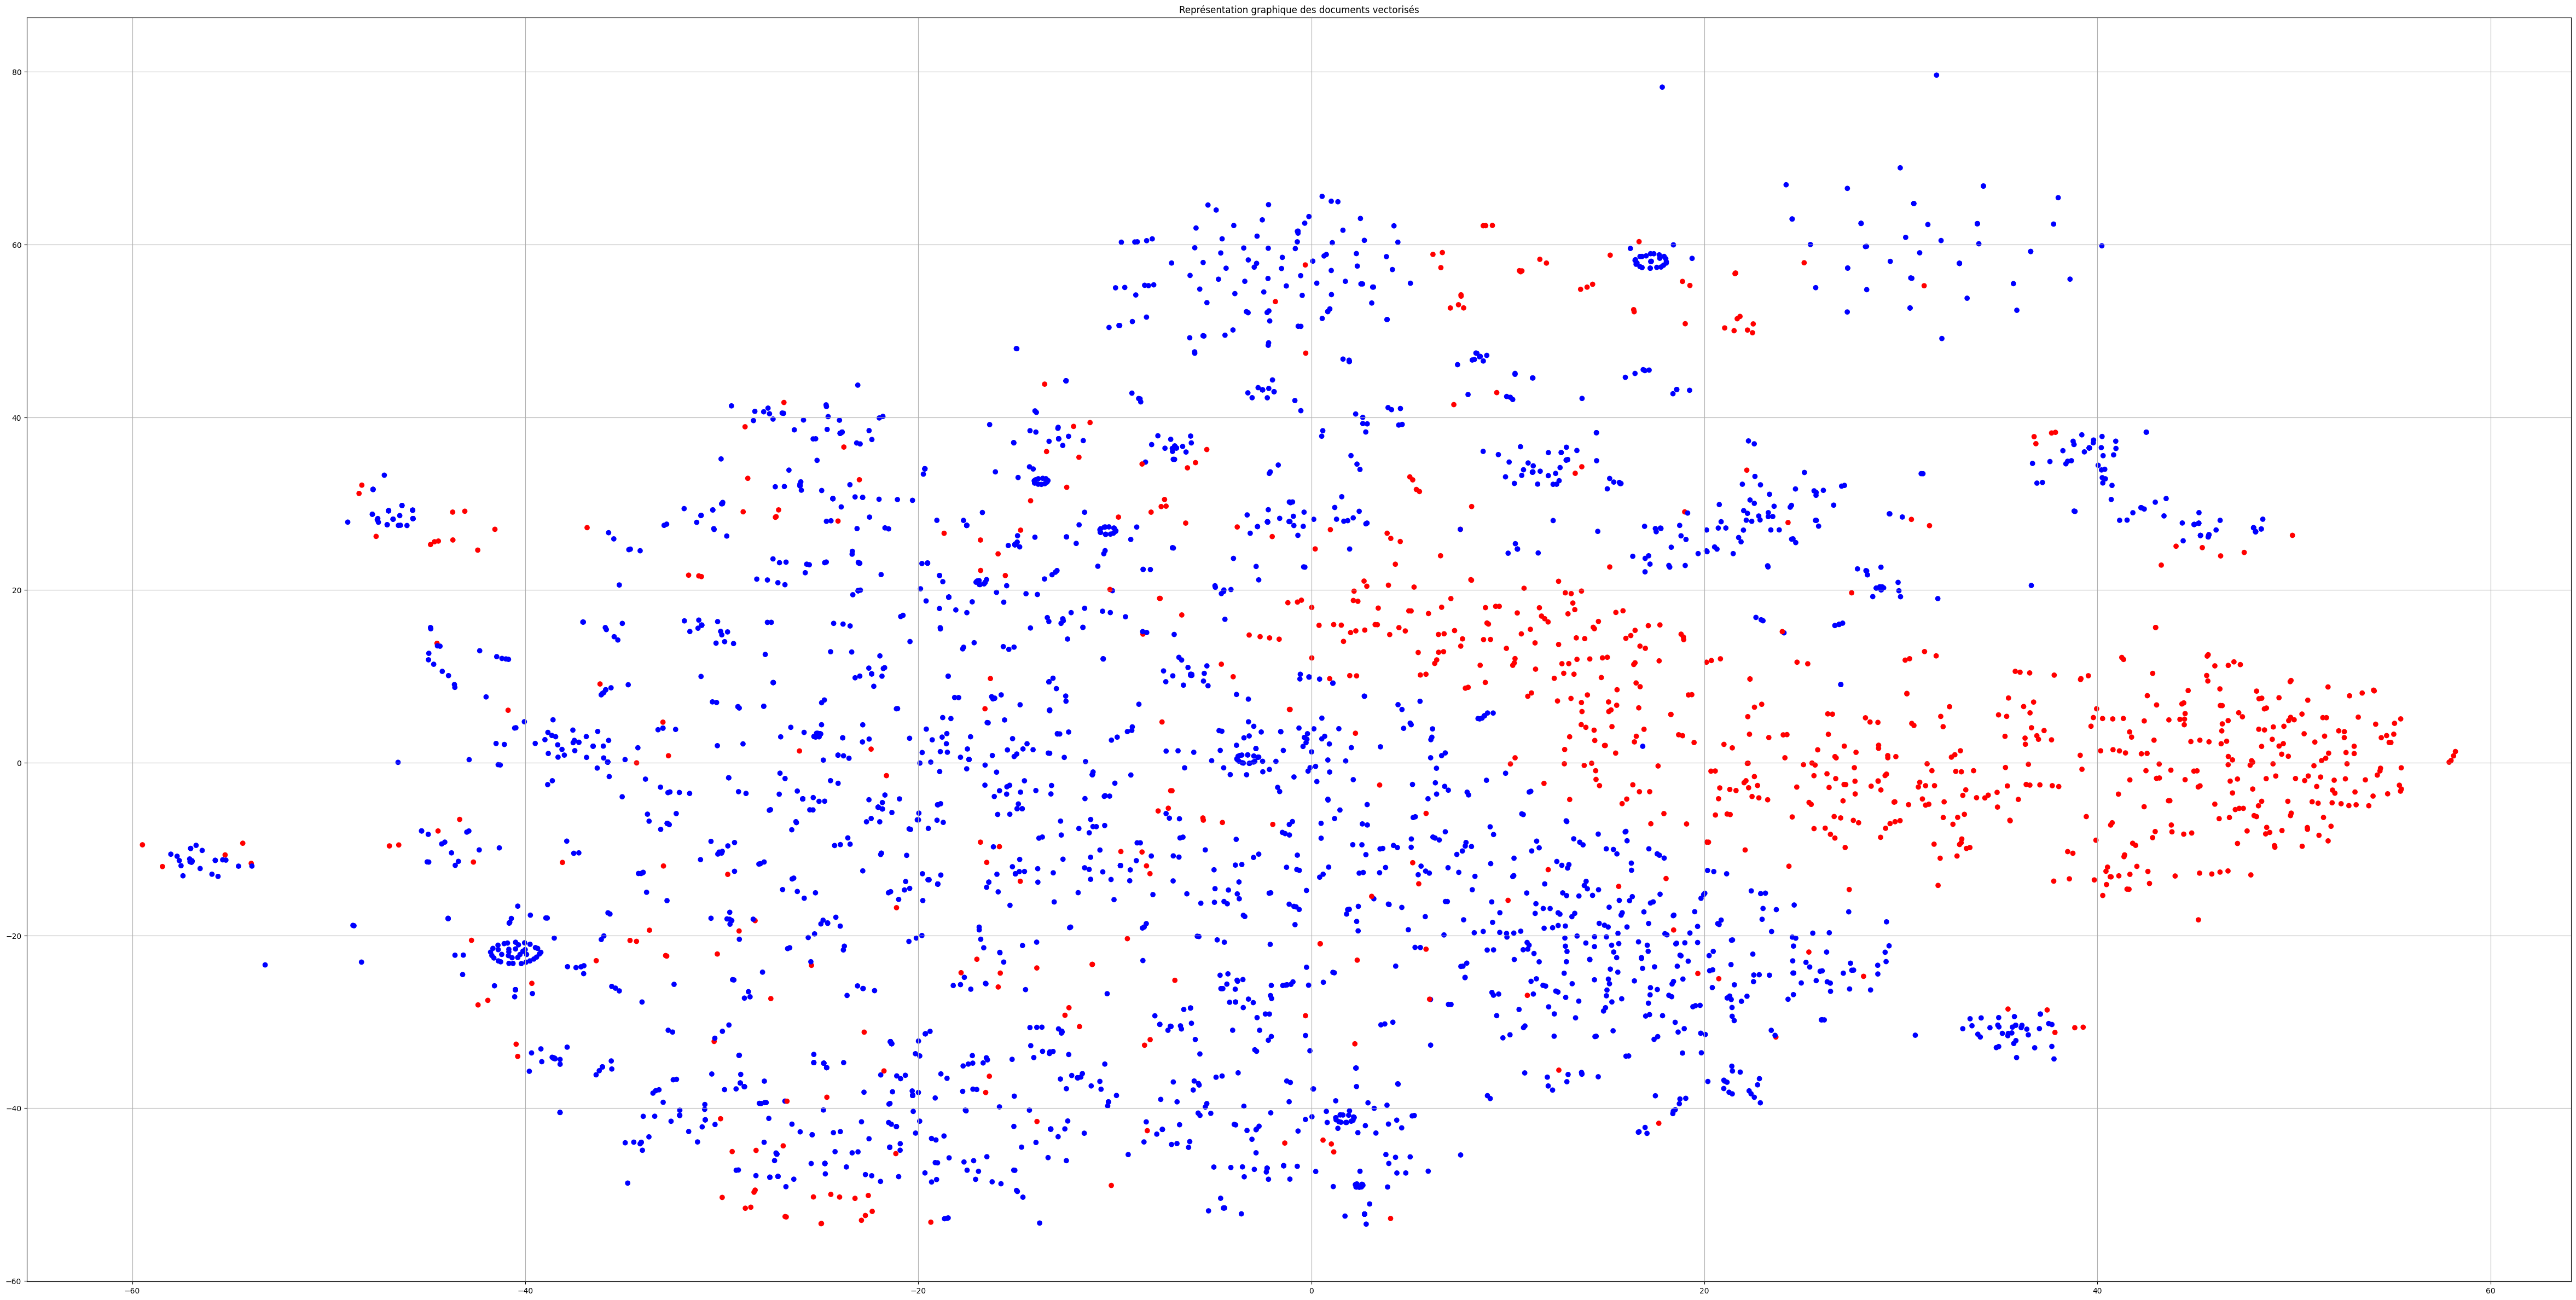

In [20]:
anomalie_sb = vetorisation_sbert(contaminated, indices)

In [22]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim) 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [23]:
anomalie_tensor = torch.tensor(anomalie_sb, dtype=torch.float32)
dataset = TensorDataset(anomalie_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder(input_dim=anomalie_sb.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0] 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0009
Epoch 2/50, Loss: 0.0007
Epoch 3/50, Loss: 0.0007
Epoch 4/50, Loss: 0.0005
Epoch 5/50, Loss: 0.0004
Epoch 6/50, Loss: 0.0005
Epoch 7/50, Loss: 0.0004
Epoch 8/50, Loss: 0.0003
Epoch 9/50, Loss: 0.0003
Epoch 10/50, Loss: 0.0004
Epoch 11/50, Loss: 0.0003
Epoch 12/50, Loss: 0.0003
Epoch 13/50, Loss: 0.0003
Epoch 14/50, Loss: 0.0004
Epoch 15/50, Loss: 0.0003
Epoch 16/50, Loss: 0.0003
Epoch 17/50, Loss: 0.0003
Epoch 18/50, Loss: 0.0004
Epoch 19/50, Loss: 0.0003
Epoch 20/50, Loss: 0.0004
Epoch 21/50, Loss: 0.0004
Epoch 22/50, Loss: 0.0003
Epoch 23/50, Loss: 0.0004
Epoch 24/50, Loss: 0.0004
Epoch 25/50, Loss: 0.0003
Epoch 26/50, Loss: 0.0003
Epoch 27/50, Loss: 0.0004
Epoch 28/50, Loss: 0.0004
Epoch 29/50, Loss: 0.0003
Epoch 30/50, Loss: 0.0003
Epoch 31/50, Loss: 0.0005
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0004
Epoch 34/50, Loss: 0.0003
Epoch 35/50, Loss: 0.0004
Epoch 36/50, Loss: 0.0004
Epoch 37/50, Loss: 0.0004
Epoch 38/50, Loss: 0.0004
Epoch 39/50, Loss: 0.


🔥 Meilleur seuil trouvé : 0.000368
📈 F1-score optimal : 0.5977

📊 Rapport de classification :

              precision    recall  f1-score   support

      Normal       0.92      0.69      0.79      2565
    Anomalie       0.47      0.83      0.60       854

    accuracy                           0.72      3419
   macro avg       0.70      0.76      0.69      3419
weighted avg       0.81      0.72      0.74      3419

AUC ROC : 0.8052


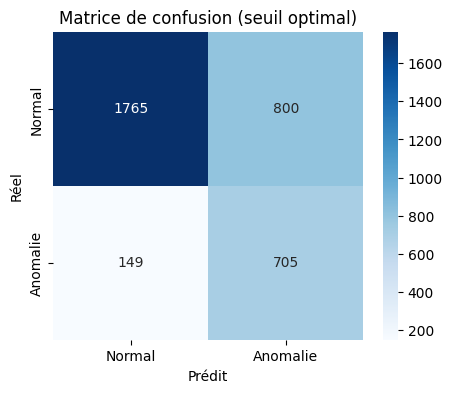

In [29]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(anomalie_sb, dtype=torch.float32)
    reconstructions = model(inputs)
    mse = torch.mean((inputs - reconstructions) ** 2, dim=1)

mse = mse.numpy()  # Convertir en numpy pour sklearn


# labels = [indices des anomalies connues]
labels = np.zeros(anomalie_sb.shape[0])
labels[indices] = 1
labels = labels.astype(int)

# le meilleur seuil basé sur le F1-score 

thresholds = np.linspace(mse.min(), mse.max(), 200)
best_f1 = 0
best_threshold = 0

f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n🔥 Meilleur seuil trouvé : {best_threshold:.6f}")
print(f"📈 F1-score optimal : {best_f1:.4f}")

# evaluer avec le meilleur seuil

y_pred = (mse > best_threshold).astype(int)
y_true = labels

print("\n📊 Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))

y_score = mse 
roc_auc = roc_auc_score(y_true, y_score)

print(f"AUC ROC : {roc_auc:.4f}")

# matrice de confusion 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()


In [30]:
mse_series = pd.Series(mse, name="MSE")
print(mse_series.describe())

count    3419.000000
mean        0.000343
std         0.000193
min         0.000024
25%         0.000185
50%         0.000334
75%         0.000476
max         0.001164
Name: MSE, dtype: float64


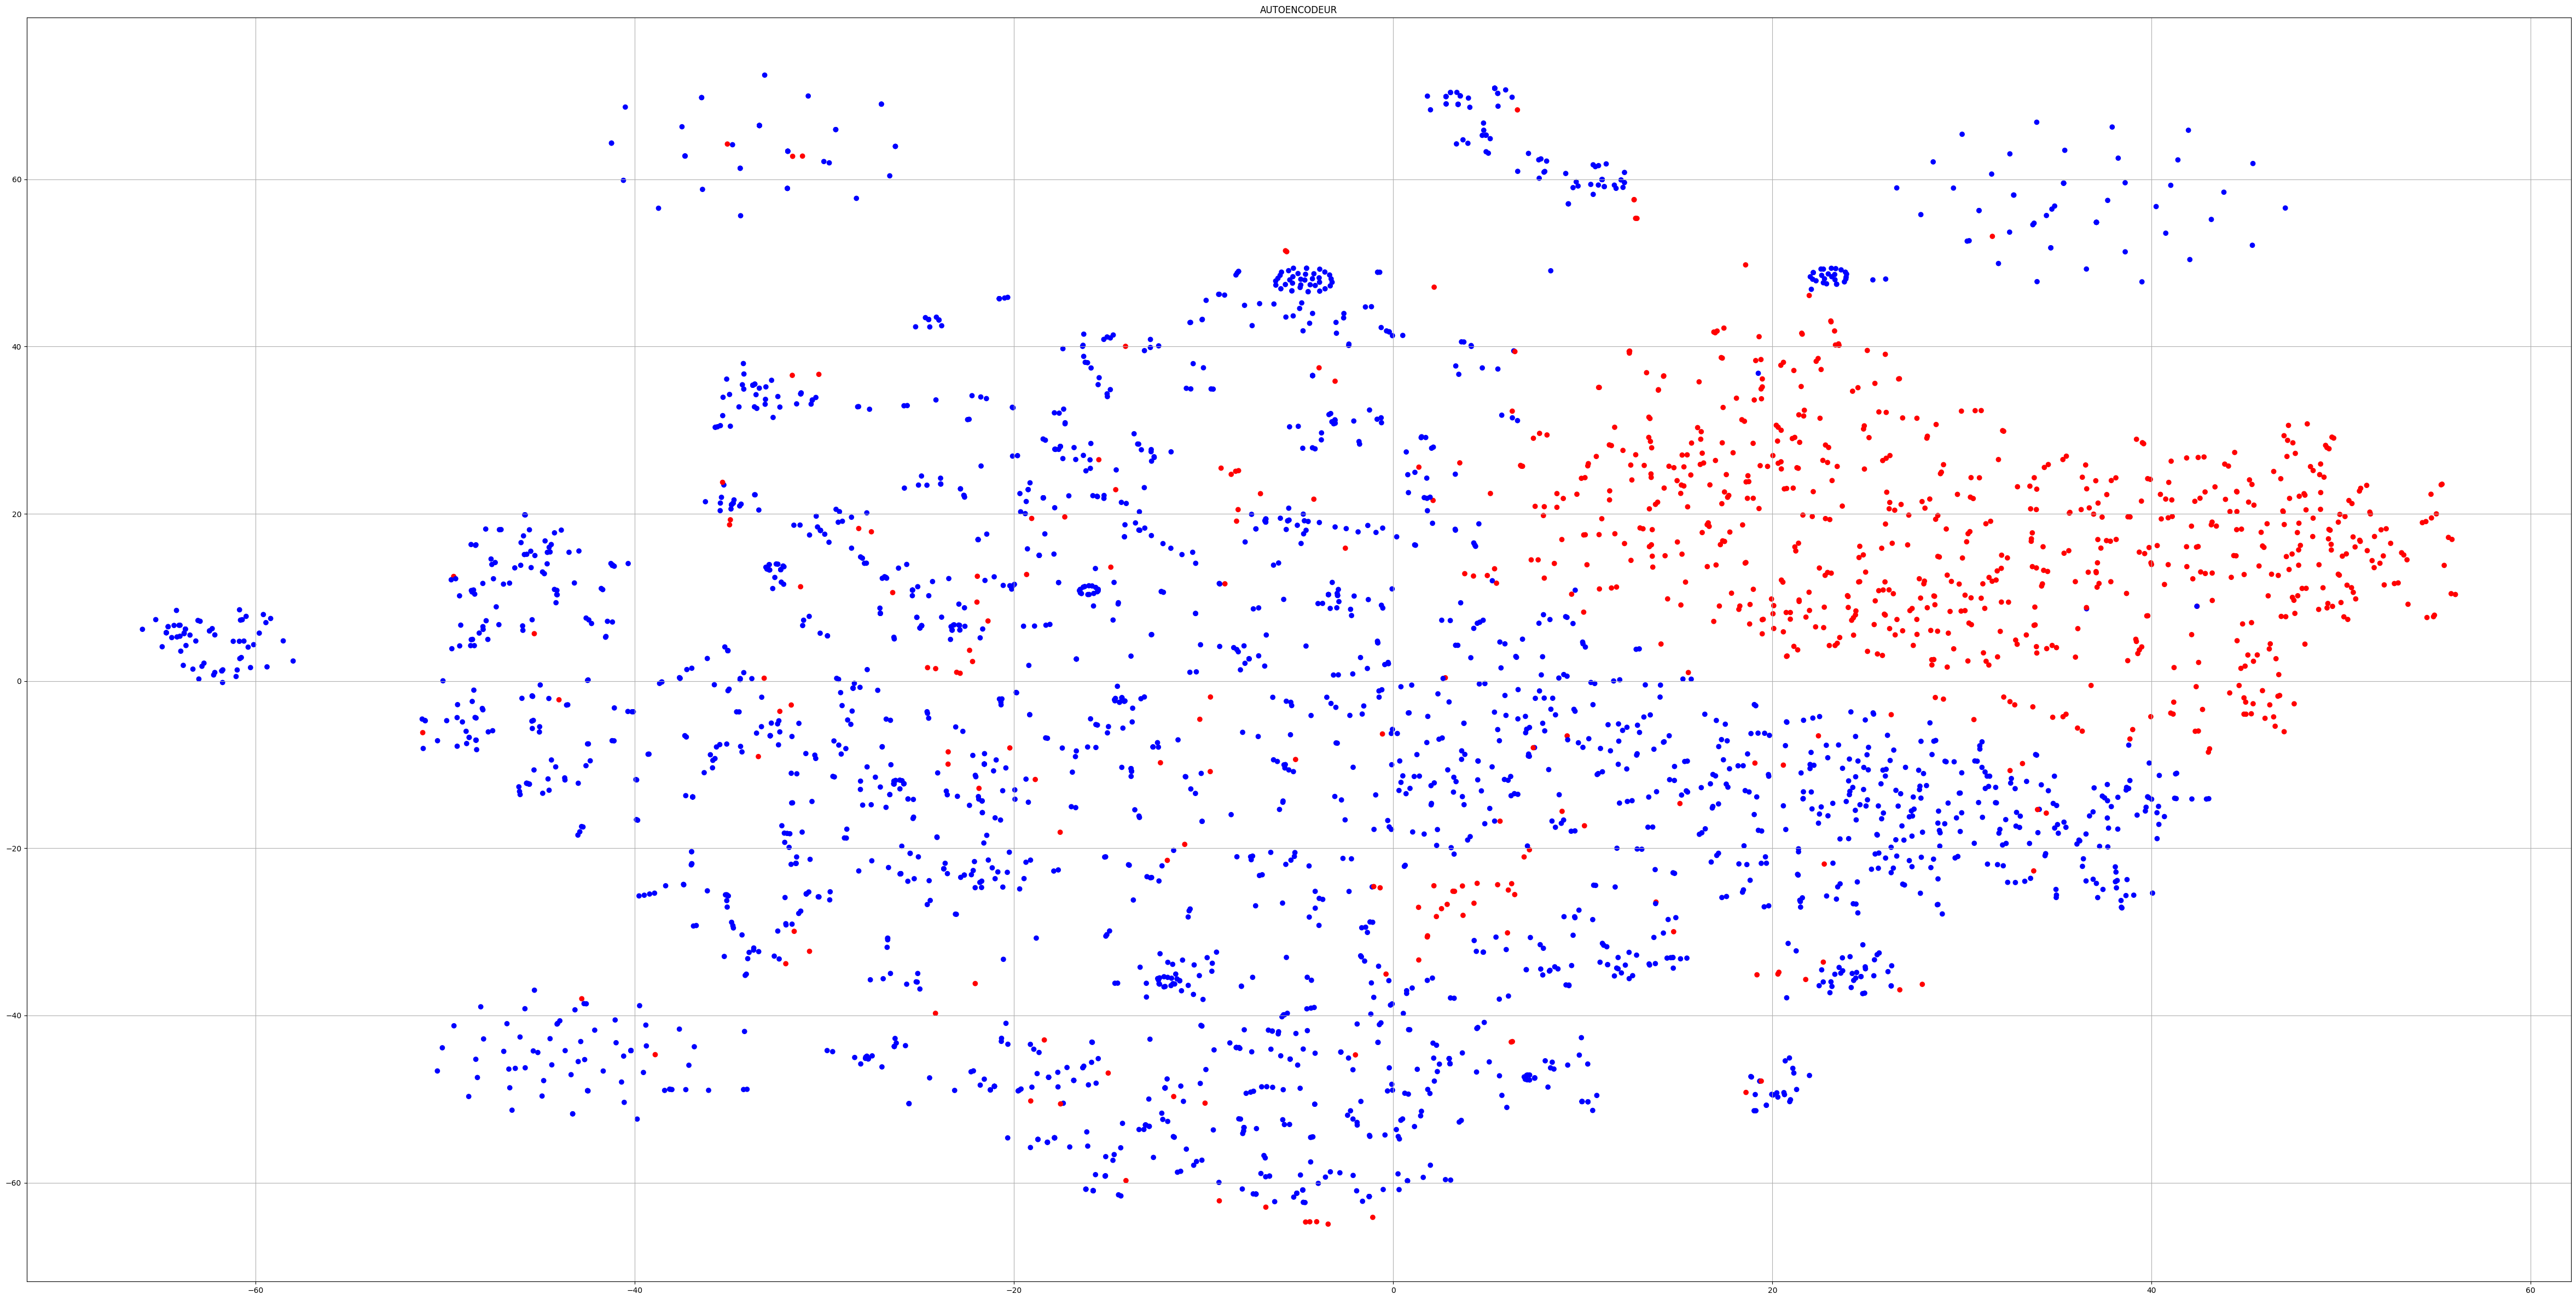

In [31]:
tsne = TSNE(n_components=2, random_state=42)  # réduire à 2 dimensions
reconstructed_2d = tsne.fit_transform(reconstructions)  # appliquer t-SNE

# couleurs des points ( rouge : anomalie, bleu : noraml)
couleurs = ['b'] * len(anomalie_sb)
for i in indices:
    if 0 <= i < len(anomalie_sb): 
        couleurs[i] = 'r'

# affichage graphique des données dans l'espace 2D
plt.figure(figsize=(60, 30)) 
plt.scatter(reconstructed_2d[:, 0], reconstructed_2d[:, 1], c=couleurs, marker='o') 

plt.title("AUTOENCODEUR")
plt.grid(True)
#plt.savefig("output.jpg")
plt.show()

In [37]:
isolation_forest = IsolationForest()
isolation_forest.fit(anomalie_sb)

IsolationForest()

In [38]:
i_forest = isolation_forest.decision_function(anomalie_sb)
anomaly_scores = -i_forest #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.89      0.78      0.84      2565
    Anomalie       0.53      0.72      0.61       854

    accuracy                           0.77      3419
   macro avg       0.71      0.75      0.72      3419
weighted avg       0.80      0.77      0.78      3419

🎯 AUC ROC : 0.8295


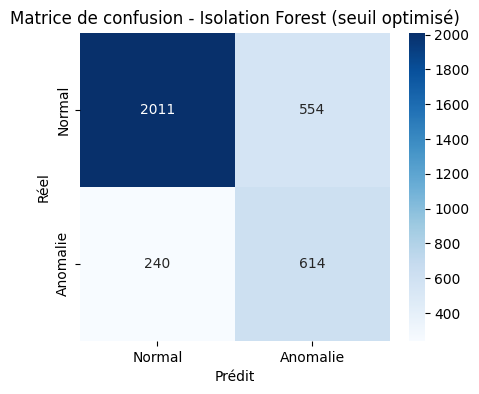

In [39]:
thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (anomaly_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (anomaly_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, anomaly_scores)

print(f"🎯 AUC ROC : {roc_auc:.4f}")
# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisé)")
plt.show()

In [50]:
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05) 
oc_svm.fit(anomalie_sb)

OneClassSVM(nu=0.05)

In [51]:
svm_pred = oc_svm.decision_function(anomalie_sb)
svm_scores = -svm_pred #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.82      0.61      0.70      2565
    Anomalie       0.34      0.59      0.43       854

    accuracy                           0.61      3419
   macro avg       0.58      0.60      0.56      3419
weighted avg       0.70      0.61      0.63      3419

🎯 AUC ROC : 0.6183


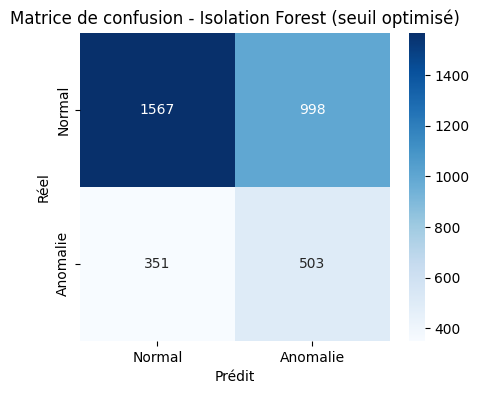

In [52]:
thresholds = np.linspace(min(svm_scores), max(svm_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (svm_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (svm_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, svm_scores)

print(f"🎯 AUC ROC : {roc_auc:.4f}")
# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisé)")
plt.show()